<a href="https://colab.research.google.com/github/susanta-pal/Deep-Learning/blob/main/head_vs_pretrained_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import all the necessary libraries

In [ ]:
import torch
import torch.utils.data
from torchvision import transforms
from torchvision.datasets import CIFAR10, FashionMNIST
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
# !pip install torchmetrics
from torchmetrics import Accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Setup the Data Class (CIFAR10 & FashionMNIST)
Always create classes for major modules. This will make your project modular, allowing you to switch different, in this case, datasets and test your model.
Out of all the advantages of this coding habit, one advantage of creating multiple objecs of the data class is that it allows you to perform ensemble learning.

In [ ]:
class DataModule():
    def __init__(self, batch_size, num_classes=10):
        super().__init__()
        self.batch_size = batch_size
        self.num_classes = num_classes
        # We define some augmentations that we would like to apply during training
        self.train_transform = transforms.Compose([

            transforms.Resize(256),
            transforms.RandomCrop(224, 4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])
        # During validation we need to only normalize and resize
        self.val_transform = transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

    # This function sets up our datasets
    # which includes downloading and applying the augmentations
    def prepare_data(self):
        self.train_set = CIFAR10(root='./data', train=True, download=True, transform=self.train_transform)
        self.val_set = CIFAR10(root='./data', train=False, download=True, transform=self.val_transform)
        total_indices = list()
        for i in range(self.num_classes):
            indices = np.where(np.asarray(self.train_set.targets)==i)[0]
            indices = np.random.choice(indices, int(0.1*len(indices))).tolist()
            total_indices.extend(indices)
        self.train_set.data = self.train_set.data[total_indices]
        self.train_set.targets = [self.train_set.targets[j] for j in total_indices]


    # This functions sets up the data loaders
    def setup(self):
        self.train_data_loader = torch.utils.data.DataLoader(self.train_set, batch_size=self.batch_size, shuffle=True)
        self.val_data_loader = torch.utils.data.DataLoader(self.val_set, batch_size=self.batch_size, shuffle=False)

    # This is simply a getter function for the training data loader
    def train_dataloader(self, prune=True):
        return self.train_data_loader

    # This is simply a getter function for the validation data loader
    def val_dataloader(self):
        return self.val_data_loader

# Setup the Model Class
Here we will define the model, its forward pass and its behaviour during each training/validation iteration

In [ ]:
class DLModel(torch.nn.Module):
    def __init__(self, num_classes, pretrained=True, num_unfreeze_layers=0, num_heads=1):
        super().__init__()
        # If you want to use the imagenet pretrained weights
        if pretrained:
            self.backbone = resnet18(weights=ResNet18_Weights.DEFAULT)
            # We freeze the entire model
            self.backbone.requires_grad_ = False
            # If you want to unfreeze some of the layers, then
            if num_unfreeze_layers > 0:
                # First find number of layers
                num_layers = 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        num_layers+=1
                # Following which unfreeze the last set of layers
                start_unfreezing_counter, counter = num_layers - num_unfreeze_layers, 0
                for name, module in self.named_modules():
                    if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear) or isinstance(module, torch.nn.BatchNorm2d):
                        counter+=1
                    if counter >= start_unfreezing_counter:
                        module.requires_grad_ = True
        # Otherwise just initialize the network from scratch
        else:
            self.backbone = resnet18(weights=None)
            self.backbone.requires_grad_ = True
        # The resnet model comes with a 1000 neuron final layer for the imagenet dataset
        self.backbone.fc = torch.nn.Sequential(
            *[torch.nn.Linear(512, 512) if i!=num_heads-1 else torch.nn.Linear(512, num_classes) for i in range(num_heads)]
        )
        self.backbone.fc.requires_grad_ = True
        # Define the objective function
        self.criterion = torch.nn.CrossEntropyLoss()
        # Define the metrics
        self.train_acc1, self.val_acc1 = Accuracy(task="multiclass", num_classes=num_classes), Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc5, self.val_acc5 = Accuracy(task="multiclass", num_classes=num_classes, top_k=5), Accuracy(task="multiclass", num_classes=num_classes, top_k=5)

    # This function sets up the optimizer and scheduler that we will use
    def configure_optimizers(self, lr, momentum, max_epochs):
        self.optimizer = torch.optim.SGD(self.parameters(), lr=lr, momentum=momentum)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=max_epochs)

    # This defines the behaviour of our model during the forward pass
    # Based on the defined behaviour, PyTorch sets up the backward pass
    def forward(self, x):
        out = self.backbone(x)
        return out

    # This function describes model behaviour per iteration during training
    def training_step(self, x, y):
        self.optimizer.zero_grad()
        preds = self.forward(x)
        self.train_acc1.update(preds, y)
        self.train_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    # Once the epoch is complete, we can call this function for inspecting the model's performance
    def on_training_epoch_end(self, loss, epoch):
        acc1, acc5 = self.train_acc1.compute().item(), self.train_acc5.compute().item()
        print(f"Epoch No: {epoch+1}\nTraining Loss: {loss}\n Training Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function describes model behaviour per iteration during validation
    def validation_step(self, x, y):
        preds = self.forward(x)
        self.val_acc1.update(preds, y)
        self.val_acc5.update(preds, y)
        loss = self.criterion(preds, y)
        return loss.item()

    # Once the validation iterations are complete, we can call this function for inspecting the model's performance
    def on_validation_epoch_end(self, loss, epoch):
        acc1, acc5 = self.val_acc1.compute().item(), self.val_acc5.compute().item()
        print(f"Validation Loss: {loss}\nValidation Accuracy: {acc1} (Top-1)\t  {acc5} (Top-5)")
        return acc1, acc5

    # This function resets the metrics so that new results can be calculated for the next epoch
    def reset_metrics(self):
        self.train_acc1.reset(), self.train_acc5.reset()
        self.val_acc1.reset(), self.val_acc5.reset()

# Putting it all together
We first define some static and global variables

In [ ]:
# First define some static variables
num_classes = 10
num_epochs = 10
batch_size = 256
# Fine-tuning and training from scratch require different sets of learning rates
lr = 0.01
momentum = 0.9
device = torch.device("cuda")


# Define the data
data_module = DataModule(batch_size=batch_size)
data_module.prepare_data()
data_module.setup()
train_loader, val_loader = data_module.train_dataloader(), data_module.val_dataloader()

Files already downloaded and verified
Files already downloaded and verified


# Training by fine-tuning some pretrained layers and a single head

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
layers_val_acc = list()
# This variable will be used to save the per-epoch training loss
layers_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=21, num_heads=1).to(device)
model.configure_optimizers(lr=lr, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    layers_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    layers_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch No: 1
Training Loss: 1.5008663922548293
 Training Accuracy: 0.4875999987125397 (Top-1)	  0.8640000224113464 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.90it/s]


Validation Loss: 1.1281530141830445
Validation Accuracy: 0.6093999743461609 (Top-1)	  0.9420999884605408 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch No: 2
Training Loss: 0.5456646114587784
 Training Accuracy: 0.8172000050544739 (Top-1)	  0.9904000163078308 (Top-5)


100%|██████████| 40/40 [00:19<00:00,  2.00it/s]


Validation Loss: 0.5282530203461647
Validation Accuracy: 0.8156999945640564 (Top-1)	  0.9904999732971191 (Top-5)


100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


Epoch No: 3
Training Loss: 0.2971368975937366
 Training Accuracy: 0.9052000045776367 (Top-1)	  0.9986000061035156 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


Validation Loss: 0.34279448091983794
Validation Accuracy: 0.8809999823570251 (Top-1)	  0.9965999722480774 (Top-5)


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch No: 4
Training Loss: 0.19672265350818635
 Training Accuracy: 0.9380000233650208 (Top-1)	  0.9994000196456909 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.88it/s]


Validation Loss: 0.3024914536625147
Validation Accuracy: 0.8934000134468079 (Top-1)	  0.9980999827384949 (Top-5)


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch No: 5
Training Loss: 0.1422109730541706
 Training Accuracy: 0.9567999839782715 (Top-1)	  0.9995999932289124 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Validation Loss: 0.3045184452086687
Validation Accuracy: 0.8931999802589417 (Top-1)	  0.9975000023841858 (Top-5)


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Epoch No: 6
Training Loss: 0.09669743366539478
 Training Accuracy: 0.973800003528595 (Top-1)	  0.9998000264167786 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.83it/s]


Validation Loss: 0.2826647896319628
Validation Accuracy: 0.902899980545044 (Top-1)	  0.9983000159263611 (Top-5)


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch No: 7
Training Loss: 0.06810554396361113
 Training Accuracy: 0.9829999804496765 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:38<00:00,  1.05it/s]


Validation Loss: 0.28859832547605035
Validation Accuracy: 0.9007999897003174 (Top-1)	  0.9979000091552734 (Top-5)


100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


Epoch No: 8
Training Loss: 0.05062259463593364
 Training Accuracy: 0.9900000095367432 (Top-1)	  0.9998000264167786 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.96it/s]


Validation Loss: 0.2759408872574568
Validation Accuracy: 0.906499981880188 (Top-1)	  0.9979000091552734 (Top-5)


100%|██████████| 20/20 [00:21<00:00,  1.07s/it]


Epoch No: 9
Training Loss: 0.034162942226976155
 Training Accuracy: 0.9947999715805054 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:20<00:00,  1.92it/s]


Validation Loss: 0.28473307061940434
Validation Accuracy: 0.9059000015258789 (Top-1)	  0.9980000257492065 (Top-5)


100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Epoch No: 10
Training Loss: 0.02701756516471505
 Training Accuracy: 0.995199978351593 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:21<00:00,  1.89it/s]

Validation Loss: 0.27277208073064685
Validation Accuracy: 0.9089000225067139 (Top-1)	  0.9980999827384949 (Top-5)


# Training by training the heads only

In [ ]:
# This variable will be used to save the per-epoch validation accuracy
head_val_acc = list()
# This variable will be used to save the per-epoch training loss
head_train_loss = list()

# Define the model
model = DLModel(num_classes=num_classes, pretrained=True, num_unfreeze_layers=0, num_heads=5).to(device)
model.configure_optimizers(lr=lr, momentum=momentum, max_epochs=num_epochs)

# Start the training loop
for epoch in range(num_epochs):
    # This is the training cycle
    model.train()
    avg_loss = 0
    # Iterate over each batch and update the model
    for x, y in tqdm(train_loader, total=len(train_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.training_step(x, y)
    avg_loss/=len(train_loader)
    head_train_loss.append(avg_loss)
    acc1, acc5 = model.on_training_epoch_end(avg_loss, epoch)

    # This is the validation cycle
    model.eval()
    avg_loss = 0
    # Iterate over each batch and get the predictions
    for x, y in tqdm(val_loader, total=len(val_loader)):
        x, y = x.to(device), y.to(device)
        avg_loss+= model.validation_step(x, y)
    avg_loss/=len(val_loader)
    acc1, acc5 = model.on_validation_epoch_end(avg_loss, epoch)
    head_val_acc.append(acc1)

    # Finally reset the metrics before going on to the next epoch
    model.reset_metrics()

100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


Epoch No: 1
Training Loss: 2.224644327163696
 Training Accuracy: 0.30140000581741333 (Top-1)	  0.7608000040054321 (Top-5)


100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Validation Loss: 2.0197146952152254
Validation Accuracy: 0.6373999714851379 (Top-1)	  0.946399986743927 (Top-5)


100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch No: 2
Training Loss: 1.5086326599121094
 Training Accuracy: 0.6376000046730042 (Top-1)	  0.9702000021934509 (Top-5)


100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


Validation Loss: 0.9666254356503486
Validation Accuracy: 0.6679999828338623 (Top-1)	  0.9790999889373779 (Top-5)


100%|██████████| 20/20 [00:23<00:00,  1.15s/it]


Epoch No: 3
Training Loss: 0.7208898797631264
 Training Accuracy: 0.7494000196456909 (Top-1)	  0.9894000291824341 (Top-5)


100%|██████████| 40/40 [00:23<00:00,  1.68it/s]


Validation Loss: 0.711945441365242
Validation Accuracy: 0.7494000196456909 (Top-1)	  0.9853000044822693 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.13s/it]


Epoch No: 4
Training Loss: 0.41166244000196456
 Training Accuracy: 0.8564000129699707 (Top-1)	  0.9968000054359436 (Top-5)


100%|██████████| 40/40 [00:23<00:00,  1.67it/s]


Validation Loss: 0.525239459425211
Validation Accuracy: 0.8147000074386597 (Top-1)	  0.9925000071525574 (Top-5)


100%|██████████| 20/20 [00:23<00:00,  1.20s/it]


Epoch No: 5
Training Loss: 0.2628731966018677
 Training Accuracy: 0.9106000065803528 (Top-1)	  0.9987999796867371 (Top-5)


100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Validation Loss: 0.39215565398335456
Validation Accuracy: 0.8640000224113464 (Top-1)	  0.996399998664856 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


Epoch No: 6
Training Loss: 0.17728603035211563
 Training Accuracy: 0.9408000111579895 (Top-1)	  0.9994000196456909 (Top-5)


100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Validation Loss: 0.33365477360785006
Validation Accuracy: 0.8866000175476074 (Top-1)	  0.9968000054359436 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


Epoch No: 7
Training Loss: 0.12600357010960578
 Training Accuracy: 0.9603999853134155 (Top-1)	  0.9995999932289124 (Top-5)


100%|██████████| 40/40 [00:24<00:00,  1.66it/s]


Validation Loss: 0.3109802894294262
Validation Accuracy: 0.8948000073432922 (Top-1)	  0.9973000288009644 (Top-5)


100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


Epoch No: 8
Training Loss: 0.07797902543097734
 Training Accuracy: 0.9746000170707703 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:23<00:00,  1.69it/s]


Validation Loss: 0.350062757357955
Validation Accuracy: 0.8845000267028809 (Top-1)	  0.9970999956130981 (Top-5)


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Epoch No: 9
Training Loss: 0.06434456519782543
 Training Accuracy: 0.9811999797821045 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:24<00:00,  1.63it/s]


Validation Loss: 0.41911671236157416
Validation Accuracy: 0.8820000290870667 (Top-1)	  0.9929999709129333 (Top-5)


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


Epoch No: 10
Training Loss: 0.04731239918619394
 Training Accuracy: 0.9861999750137329 (Top-1)	  1.0 (Top-5)


100%|██████████| 40/40 [00:24<00:00,  1.66it/s]

Validation Loss: 0.34800203144550323
Validation Accuracy: 0.896399974822998 (Top-1)	  0.9976000189781189 (Top-5)


# Comparisons
Now that we have evaluated the models for two different datasets, let us compare them
We expect that the performance of ResNet18 on MNIST should be considerably worse than CIFAR10 due to reduced domain adaptability

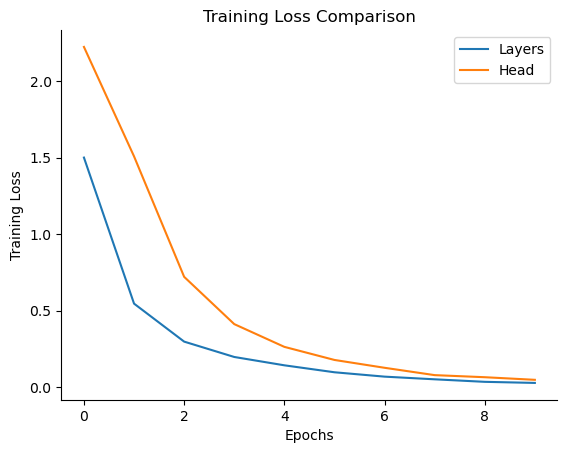

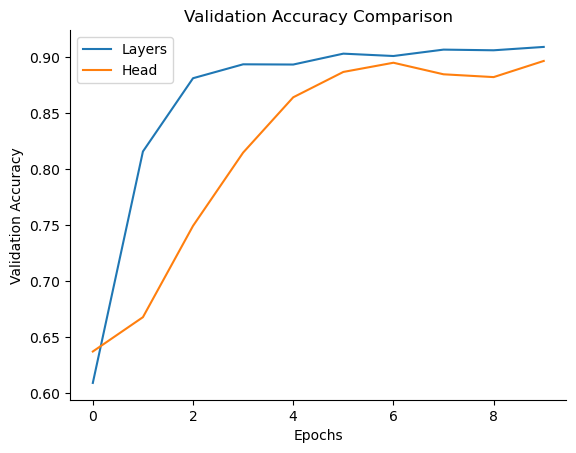

In [ ]:
# Comparing the Training loss per epoch
sns.lineplot(x=np.arange(len(layers_train_loss)), y=layers_train_loss, label="Layers")
sns.lineplot(x=np.arange(len(head_train_loss)), y=head_train_loss, label="Head")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
sns.despine()
plt.title("Training Loss Comparison")
plt.show()
plt.close()

# Comparing the validation Accuracies per epoch
sns.lineplot(x=np.arange(len(layers_val_acc)), y=layers_val_acc, label="Layers")
sns.lineplot(x=np.arange(len(head_val_acc)), y=head_val_acc, label="Head")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
sns.despine()
plt.title("Validation Accuracy Comparison")
plt.show()